Number of nodes after removing isolated nodes: 4039
Number of edges after removing isolated nodes: 88234


c:\Python312\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


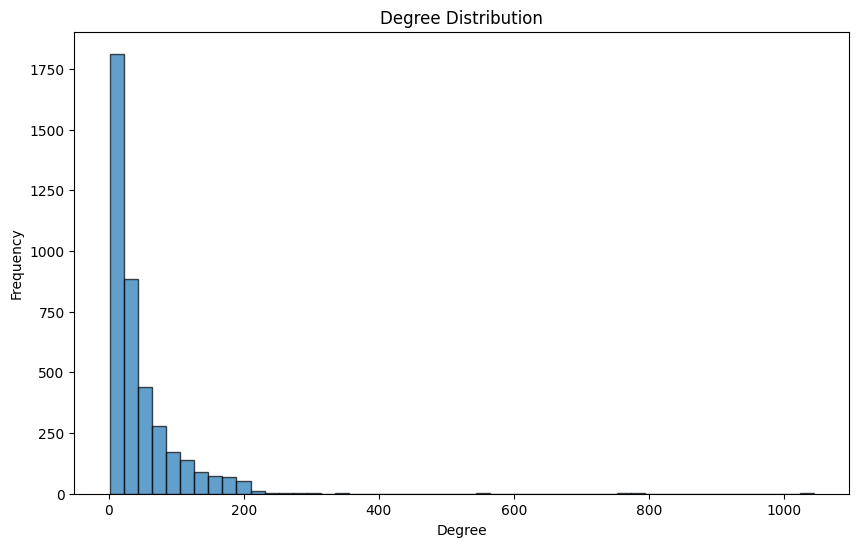

Best KMeans parameters: {'n_clusters': 3}, Silhouette Score: 0.5819397568702698
Best DBSCAN parameters: {'eps': 0.3, 'min_samples': 10}, Silhouette Score: 0.4093981683254242
Best Agglomerative Clustering parameters: {'n_clusters': 4, 'linkage': 'average'}, Silhouette Score: 0.591874361038208


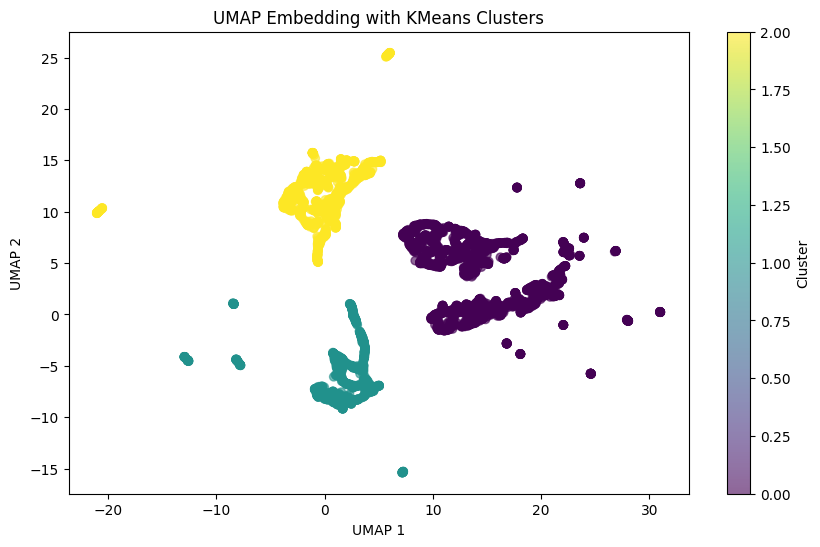

In [2]:
# Import necessary libraries
import pandas as pd
import networkx as nx
from igraph import Graph
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import silhouette_score
import umap
import numpy as np

# Load the dataset
filename = 'facebook_combined.txt'
nx_graph = nx.read_edgelist(filename, create_using=nx.Graph(), nodetype=int)
igraph_fb = Graph.Read_Edgelist(filename, directed=False)

# Remove isolated nodes
isolated_nodes = list(nx.isolates(nx_graph))
nx_graph.remove_nodes_from(isolated_nodes)
igraph_fb = Graph.TupleList(nx.to_edgelist(nx_graph), directed=False)

# Display basic information about the graph after removing isolated nodes
print(f"Number of nodes after removing isolated nodes: {nx_graph.number_of_nodes()}")
print(f"Number of edges after removing isolated nodes: {nx_graph.number_of_edges()}")

# Feature Engineering
# Calculate node degree
node_degree = igraph_fb.degree()
# Calculate clustering coefficient
clustering_coefficient = igraph_fb.transitivity_local_undirected()

# Mean Neighbor Degree
sub_avgdeg = []

for vertex in igraph_fb.vs:
    neighbors_within_2_hops = igraph_fb.neighborhood(vertex, order=2)
    subgraph = igraph_fb.subgraph(neighbors_within_2_hops)
    sub_avgdeg.append(np.array(subgraph.degree()).mean())

# Create a dataframe for the features
df = pd.DataFrame({
    'node': range(len(node_degree)),
    'degree': node_degree,
    'clustering_coefficient': clustering_coefficient,
    'mean_neighbor_degree': sub_avgdeg
})

# Handle missing values
imputer = SimpleImputer(strategy='mean')
df_imputed = imputer.fit_transform(df[['degree', 'clustering_coefficient', 'mean_neighbor_degree']])

# Data Preparation
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_imputed)

# Apply UMAP for dimensionality reduction
umap_embedding = umap.UMAP(n_neighbors=15, n_components=2, random_state=42)
X_umap = umap_embedding.fit_transform(X_scaled)

# Exploratory Data Analysis
# Plot degree distribution
plt.figure(figsize=(10, 6))
plt.hist(df['degree'], bins=50, edgecolor='k', alpha=0.7)
plt.title('Degree Distribution')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.show()

# Custom function to perform grid search for clustering algorithms
def custom_grid_search(estimator, param_grid, X):
    best_score = -1
    best_params = None
    for params in param_grid:
        estimator.set_params(**params)
        labels = estimator.fit_predict(X)
        if len(set(labels)) > 1:  # Avoid single cluster
            score = silhouette_score(X, labels)
            if score > best_score:
                best_score = score
                best_params = params
    return best_params, best_score

# Define the parameter grids
kmeans_param_grid = [
    {'n_clusters': n} for n in [3, 4, 5, 6, 7, 8, 9, 10]
]
dbscan_param_grid = [
    {'eps': eps, 'min_samples': min_samples} for eps in [0.3, 0.4, 0.5, 0.6, 0.7] for min_samples in [3, 5, 7, 10]
]
agglo_param_grid = [
    {'n_clusters': n_clusters, 'linkage': linkage} for n_clusters in [3, 4, 5, 6, 7, 8] for linkage in ['ward', 'complete', 'average', 'single']
]

# Perform grid search for each clustering algorithm using UMAP embeddings
best_kmeans_params, best_kmeans_score = custom_grid_search(KMeans(random_state=42), kmeans_param_grid, X_umap)
best_dbscan_params, best_dbscan_score = custom_grid_search(DBSCAN(), dbscan_param_grid, X_umap)
best_agglo_params, best_agglo_score = custom_grid_search(AgglomerativeClustering(), agglo_param_grid, X_umap)

# Print the best parameters and scores
print(f"Best KMeans parameters: {best_kmeans_params}, Silhouette Score: {best_kmeans_score}")
print(f"Best DBSCAN parameters: {best_dbscan_params}, Silhouette Score: {best_dbscan_score}")
print(f"Best Agglomerative Clustering parameters: {best_agglo_params}, Silhouette Score: {best_agglo_score}")

# Visualization of UMAP embedding
plt.figure(figsize=(10, 6))
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=KMeans(n_clusters=best_kmeans_params['n_clusters'], random_state=42).fit_predict(X_umap), cmap='viridis', alpha=0.6)
plt.title('UMAP Embedding with KMeans Clusters')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.colorbar(label='Cluster')
plt.show()
